In [1]:
import gym
import numpy as np

In [2]:
env = gym.make("FrozenLake8x8-v1")
env.reset()
env.render()
iterations = 2000


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [3]:
"""
tree backup implementation on the frozen lake
"""
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class tree_backup():
    def __init__(self,
                env,gamma,epsilon,alpha, n):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.n = n
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        #save the reward, state and action of each step in buffer arrays
        r_buffer = []
        s_buffer = []
        a_buffer = []
        n = self.n
        t = 0
        T = 1000
        
        
        #initialize the envrionment and buffer
        state = self.env.reset()
        action = self.choose_action(state)
        
        s_buffer.insert(t,state)
        a_buffer.insert(t,action)
        r_buffer.insert(t,0)
        
        while True:
            if t < T:
            #run a step here; move the run_step() function to here instead of a separated function
                state, reward, done, _ = self.env.step(action)
                
                # we modify the reward function to make the agent know that hole is not expected
                # the reward to goal is big because in 8*8 map, it takes more steps to the goal(much less chance) so we need to give bigger reward
                if reward == 0 and done:
                    reward = -0.5
                if reward == 1 and done:
                    reward = 10
                
                r_buffer.insert(t+1,reward)
                s_buffer.insert(t+1, state)
              
            #store the reward, state and action
                episode_return += reward
             #if terminated, then T = t + 1
                if done:
                    T = t + 1
                else:
                    action = self.choose_action(state)
                    a_buffer.insert(t+1, action)

            tao = t + 1 - n
            G = 0
            if tao >= 0:
                if (t+1) >= T:
                    G = r_buffer[T]
                else:
                    P = self.action_possibility(s_buffer[t+1])
                    "here is the sum of probability * action value"
                    V = P * self.q[s_buffer[t+1]]
                    G = r_buffer[t+1] + self.gamma * sum(V)
                    k = min(t,T-1)
                    while k > tao: 
                        k_state = s_buffer[k]
                        k_action = a_buffer[k]
                        k_reward = r_buffer[k]
                        
                        P = self.action_possibility(s_buffer[k])
                        V1 = 0
                        for i in range(0,4):
                            if i != k_action:
                                V1 += P[i] * self.q[k_state][i]
                        V2 = P[k_action] * G
                        G = r_buffer[k] + self.gamma * V1 + self.gamma * V2
                        k -= 1
                tao_state = s_buffer[tao]
                tao_action = a_buffer[tao]
                self.q[tao_state][tao_action] += self.alpha * (G - self.q[tao_state][tao_action])
            t = t + 1
            if tao == T-1:
                break
           
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            if episode_return > 0:
                episode_return = 1
            else:
                episode_return = 0
            returns.append(episode_return)
        return returns

    

In [4]:
env.reset()
tree_agent = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 3)

tree_results = tree_agent.learn_task(iterations)

100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 231.26it/s]


In [5]:
sum(tree_results)

145

In [6]:
env.reset()

tree_agent2 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 2)

tree_results_2 = tree_agent2.learn_task(iterations)

100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 297.51it/s]


In [7]:
sum(tree_results_2)

471

In [8]:
env.reset()

tree_agent1 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 1)

tree_results_1 = tree_agent1.learn_task(iterations)

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 451.26it/s]


In [9]:
sum(tree_results_1)

552

In [10]:
env.reset()

tree_agent4 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 4)

tree_results_4 = tree_agent4.learn_task(iterations)

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 195.44it/s]


In [11]:
sum(tree_results_4)

207

In [12]:
env.reset()

tree_agent5 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 5)

tree_results_5 = tree_agent5.learn_task(iterations)
sum(tree_results_5)

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 175.09it/s]


97

In [13]:
env.reset()

tree_agent10 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1, n = 10)

tree_results_10 = tree_agent10.learn_task(iterations)
sum(tree_results_10)

100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 108.59it/s]


77

In [14]:
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class ESarsa():
    def __init__(self,
                env,gamma,epsilon,alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
            
    def update_q(self, state, action, next_state, next_action, reward):
        P = self.action_possibility(next_state)        
        V = P * self.q[next_state]
        self.q[state][action] += self.alpha * (reward + self.gamma*sum(V) - self.q[state][action])
        
    
    def run_step(self, state, action):
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.choose_action(next_state)
        "we modify the reward function to make the agent know that hole is not expected"
        if reward == 0 and done:
            reward = -0.5
        if reward == 1 and done:
            reward = 10
        
        self.update_q(state,action,next_state,next_action,reward)
        return next_state, next_action,reward,done
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        state = self.env.reset()
        action = self.choose_action(state)
        
        while True:
            state, action, reward,done = self.run_step(state,action)
            episode_return += reward
            if done:
                break
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            if episode_return > 0:
                episode_return = 1
            else:
                episode_return = 0
            returns.append(episode_return)
#             if episode_return > 0:
#                 self.epsilon -= 0.01
        return returns

    

In [15]:
env.reset()  
agent = ESarsa(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1)
es = agent.learn_task(iterations)

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 452.09it/s]


In [16]:
sum(es)

614

In [17]:
np.average(es)

0.307

In [18]:
from matplotlib import pyplot as plt
from scipy.interpolate import pchip
import pandas as pd

def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

window_size = iterations//10

tree_1 = moving_average(tree_results_1,window_size)
tree_2 = moving_average(tree_results_2,window_size)
tree_3 = moving_average(tree_results,window_size)
tree_4 = moving_average(tree_results_4,window_size)
tree_5 = moving_average(tree_results_5,window_size)
tree_10 = moving_average(tree_results_10,window_size)

es_smooth = moving_average(es, window_size)


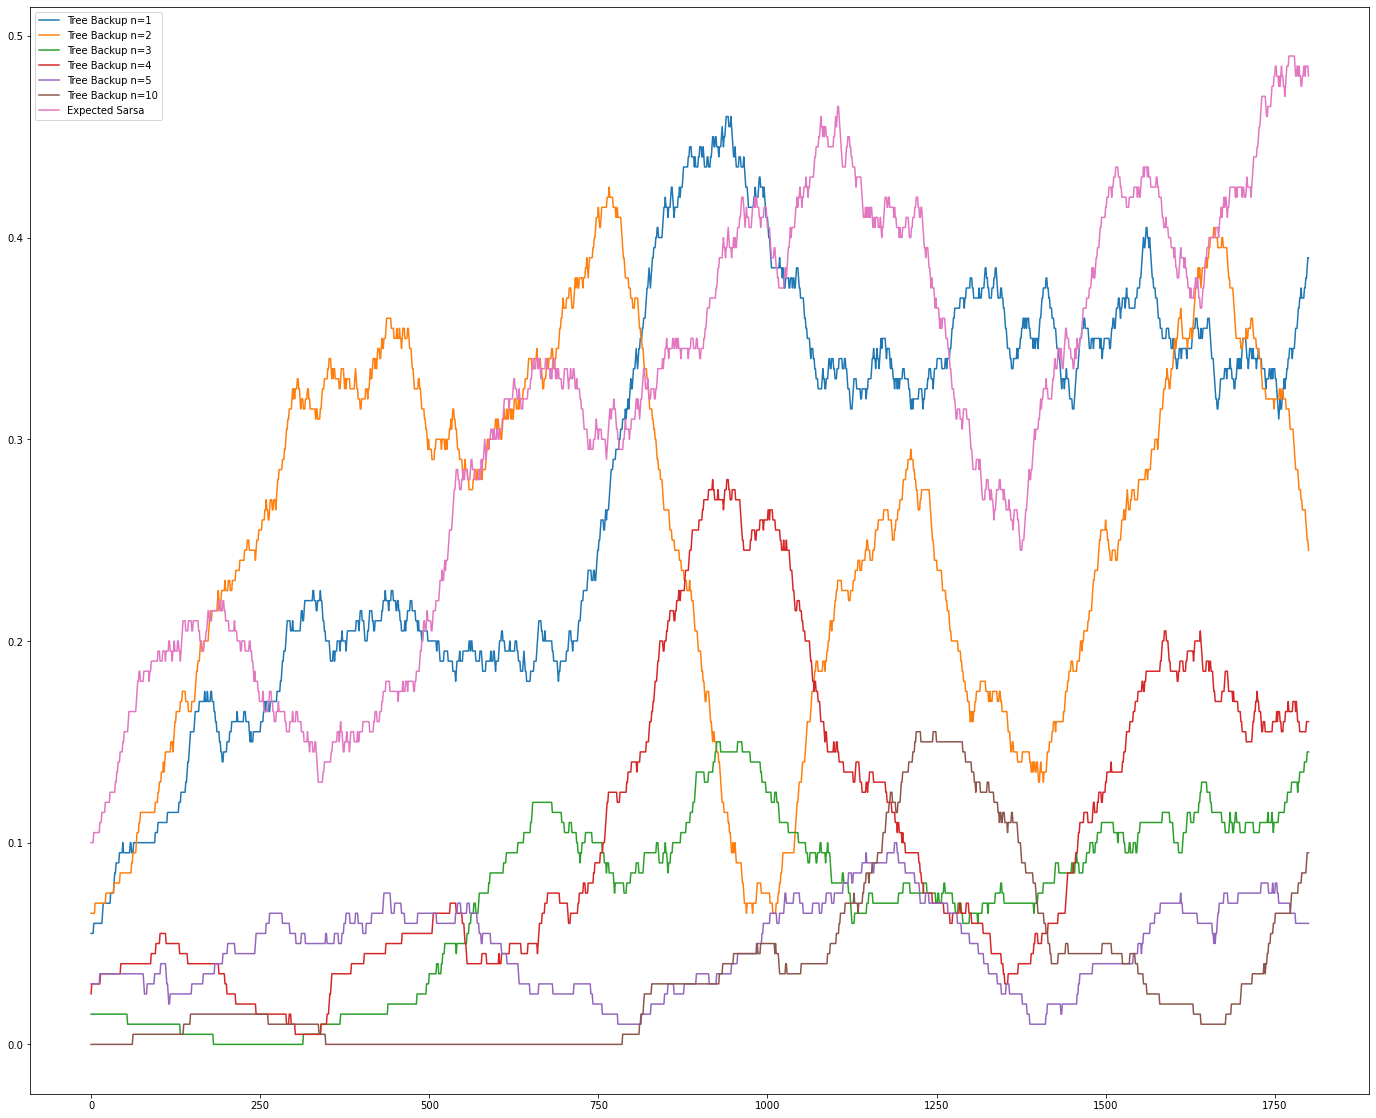

In [20]:
plt.plot(tree_1, label = "Tree Backup n=1")
plt.plot(tree_2, label = "Tree Backup n=2")
plt.plot(tree_3, label = "Tree Backup n=3")
plt.plot(tree_4, label = "Tree Backup n=4")
plt.plot(tree_5, label = "Tree Backup n=5")
plt.plot(tree_10, label = "Tree Backup n=10")
plt.plot(es_smooth,label="Expected Sarsa")
plt.legend()
plt.rcParams["figure.figsize"] = [24,20]
plt.show()